# 1.0 CitiBike Viz

* add elevation https://developers.google.com/maps/documentation/elevation/start
* visualize using ipyleaflet
* time vs station depart/arrive
* age vs station depart/arrive
* ave vs time depart/arrive
* station-station distances and google maps biking distances
* add neighborhood categories to stations

In [1]:
from clustergrammer2 import net
df = {}

In [2]:
import himc_helper_functions_v0_12_3 as hf
import umap

In [3]:
def make_umap_plot(df, cat_index, colors_dict, title, min_dist=1.0, n_neighbors=20, s=5.0, alpha=1.0, 
                   figsize=(10,10)):
    cols = df.columns.tolist()
    cats = [x[cat_index] for x in cols]
    list_colors = [colors_dict[x.split(': ')[1]] for x in cats]
    
    
    
    embedding = umap.UMAP(n_neighbors=n_neighbors, random_state=99,
                          min_dist=min_dist,
                          metric='correlation').fit_transform(df.transpose())
    
    df_umap = pd.DataFrame(data=embedding, columns=['x', 'y'])
    df_umap.plot(kind='scatter', x='x', y='y',  c=list_colors, alpha=alpha, s=s, figsize=figsize, 
                 title=title)
    
    return df_umap

In [4]:
def make_df_from_cols(cols):
    inst_col = cols[0]

    cat_titles = []
    for inst_info in inst_col[1:]:
        inst_title = inst_info.split(': ')[0]
        cat_titles.append(inst_title)

    clean_cols = []
    for inst_col in cols:
        inst_clean = []
        for inst_info in inst_col:
            if ': ' in inst_info:
                inst_clean.append(inst_info.split(': ')[1])
            else:
                inst_clean.append(inst_info)
        clean_cols.append(tuple(inst_clean))

    df_ini = pd.DataFrame(data=clean_cols).set_index(0)
    mat = df_ini.get_values()
    rows = df_ini.index.tolist()

    print(mat.shape)
    print(len(rows))
    print(len(clean_cols))

    df_meta = pd.DataFrame(data=mat, index=rows, columns=cat_titles)

    return df_meta

In [5]:
import pandas as pd
from copy import deepcopy
import numpy as np

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [7]:
df_ini = pd.read_csv('../data/big_data/201907-citibike-tripdata.csv')
print(df_ini.shape[0]/1e6, 'million rides')

2.181064 million rides


In [8]:
inst_year = 2020

In [9]:
mean_age = 40

In [10]:
df_ini.columns.tolist()

['tripduration',
 'starttime',
 'stoptime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'usertype',
 'birth year',
 'gender']

In [11]:
all_stations = df_ini['start station name'].value_counts().index.tolist()
for inst_station in all_stations:
    if '&' not in inst_station:
        print(inst_station)

Pershing Square North
Pier 40 - Hudson River Park
Great Jones St
Pershing Square South
West Thames St
Old Fulton St
Cherry St
Soissons Landing
Water - Whitehall Plaza
Yankee Ferry Terminal
Picnic Point
Brooklyn Bridge Park - Pier 2
Washington Park
10 Hudson Yards


### Station Metadata

In [12]:
df_meta = pd.DataFrame(all_stations, index=all_stations, columns=['station crossing'])
for inst_point in ['start', 'end']:
    
    # x 
    df_meta['cross-y'] = df_meta['station crossing'].apply(lambda x: str(x).split(' & ')[0] if '&' in str(x) else x)
    
    # y 
    df_meta['cross-x'] = df_meta['station crossing'].apply(lambda x: str(x).split(' & ')[1] if '&' in str(x) else x)
    
    # Street
    ser_st = pd.Series(index=df_meta['cross-y'].index.tolist())
    ser_ave = pd.Series(index=df_meta['cross-y'].index.tolist())
    
    # Find Street and Avenue
    for inst_row in ser_st.index.tolist():
        inst_st = 'N.A.'
        inst_ave = 'N.A.'
        
        # Find street
        if ' St' in df_meta.loc[inst_row, 'cross-y']:
            inst_st = df_meta.loc[inst_row, 'cross-y']
        elif ' St' in df_meta.loc[inst_row, 'cross-x']:
            inst_st = df_meta.loc[inst_row, 'cross-x']
            
        # Find Avenue
        if ' Ave' in df_meta.loc[inst_row, 'cross-y']:
            inst_ave = df_meta.loc[inst_row, 'cross-y']
        elif ' Ave' in df_meta.loc[inst_row, 'cross-x']:
            inst_ave = df_meta.loc[inst_row, 'cross-x']
        
        ser_st[inst_row] = inst_st
        ser_ave[inst_row] = inst_ave

df_meta['St'] = ser_st
df_meta['Ave'] = ser_ave

### Calc Destination Distributions
Save positions of stations

In [13]:
all_stations = sorted(df_ini['start station name'].value_counts().index.tolist())
len(all_stations)

df_dest = pd.DataFrame(0, index=all_stations, columns=all_stations)
for inst_station in all_stations:
    inst_df = df_ini.loc[df_ini['start station name'] == inst_station]
    ser_destination = inst_df['end station name'].value_counts()
    ser_destination.name = inst_station
    
    df_dest[inst_station] = ser_destination
    
    df_meta.loc[inst_station, 'start station latitude'] = inst_df['start station latitude'].mean()
    df_meta.loc[inst_station, 'start station longitude'] = inst_df['start station longitude'].mean()    
    
    # save average departing age
    df_meta.loc[inst_station, 'departing age'] = inst_year - inst_df['birth year'].mean() - mean_age
    
    inst_df = df_ini.loc[df_ini['end station name'] == inst_station]    
    df_meta.loc[inst_station, 'arriving age'] = inst_year - inst_df['birth year'].mean() - mean_age   
    
df_dest.shape

(787, 787)

In [16]:
df_dest = df_dest.fillna(0)
df_dest.head()

,1 Ave & E 110 St,1 Ave & E 16 St,1 Ave & E 18 St,1 Ave & E 30 St,1 Ave & E 44 St,1 Ave & E 62 St,1 Ave & E 68 St,1 Ave & E 78 St,1 Ave & E 94 St,1 Pl & Clinton St,...,Willoughby Ave & Tompkins Ave,Willoughby Ave & Walworth St,Willoughby Ave & Wyckoff Ave,Willoughby St & Fleet St,Wolcott St & Dwight St,Wyckoff Av & Jefferson St,Wyckoff St & 3 Ave,Wyckoff St & Bond St,Wythe Ave & Metropolitan Ave,Yankee Ferry Terminal
1 Ave & E 110 St,100.0,2.0,0.0,0.0,9.0,7.0,15.0,18.0,76.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 Ave & E 16 St,1.0,121.0,99.0,73.0,14.0,6.0,17.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1 Ave & E 18 St,0.0,142.0,102.0,102.0,5.0,8.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0
1 Ave & E 30 St,0.0,165.0,160.0,35.0,6.0,7.0,10.0,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1 Ave & E 44 St,0.0,41.0,57.0,83.0,35.0,13.0,15.0,7.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,15.0,0.0


In [17]:
df_meta.head()

,station crossing,cross-y,cross-x,St,Ave,start station latitude,start station longitude,departing age,arriving age
Pershing Square North,Pershing Square North,Pershing Square North,Pershing Square North,N.A.,N.A.,40.751873,-73.977706,1.690176,2.188353
12 Ave & W 40 St,12 Ave & W 40 St,12 Ave,W 40 St,W 40 St,12 Ave,40.760875,-74.002777,1.435184,1.386848
West St & Chambers St,West St & Chambers St,West St,Chambers St,West St,N.A.,40.717548,-74.013221,-0.236967,-0.257055
8 Ave & W 31 St,8 Ave & W 31 St,8 Ave,W 31 St,W 31 St,8 Ave,40.750585,-73.994685,2.172538,0.934610
E 17 St & Broadway,E 17 St & Broadway,E 17 St,Broadway,E 17 St,N.A.,40.737050,-73.990093,0.143626,0.261608


In [18]:
df_cat = deepcopy(df_dest)
add_cat_list = ['cross-x', 'cross-y', 'departing age']
new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.columns.tolist(), df_meta=df_meta)

add_cat_list = ['cross-x', 'cross-y', 'arriving age']
new_rows = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.index.tolist(), df_meta=df_meta)

df_cat.columns = new_cols
df_cat.index = new_rows

In [19]:
df_norm = net.umi_norm(df_cat)

### Identify Clusters (Neighborhoods)

In [20]:
group_level = 6
net.load_df(df_norm)
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.cluster()
net.dendro_cats(axis='col', dendro_level=group_level)
net_clust = net.export_df()
cols = net_clust.columns.tolist()
ser_cluster = make_df_from_cols(cols)['Group ' + str(group_level)]
ser_cluster.head()

(787, 4)
787
787


1 Ave & E 110 St    cat-10
1 Ave & E 16 St     cat-12
1 Ave & E 18 St     cat-12
1 Ave & E 30 St     cat-12
1 Ave & E 44 St     cat-11
Name: Group 6, dtype: object

In [21]:
df_meta['Cluster'] = ser_cluster

In [22]:
ser_counts = ser_cluster.value_counts()
ser_counts = ser_counts[sorted(ser_counts.index.tolist())]
ser_counts

cat-1       4
cat-10     61
cat-11     48
cat-12     84
cat-2      82
cat-3       1
cat-4      84
cat-5     127
cat-6       2
cat-7      75
cat-8     153
cat-9      66
Name: Group 6, dtype: int64

### Map Out Neighborhoods

In [23]:
name_dict = {}
name_dict['cat-1'] = 'Governors Island'
name_dict['cat-2'] = 'Queens'
name_dict['cat-3'] = 'Queens'
name_dict['cat-4'] = 'North Brooklyn'
name_dict['cat-5'] = 'South Brooklyn'
name_dict['cat-6'] = 'Central Brooklyn'
name_dict['cat-7'] = 'Central Brooklyn'
name_dict['cat-8'] = 'Lower Manhattan'
name_dict['cat-9'] = 'Upper West Side'
name_dict['cat-10'] = 'Harlem'
name_dict['cat-11'] = 'Upper East Side'
name_dict['cat-12'] = 'Midtown'

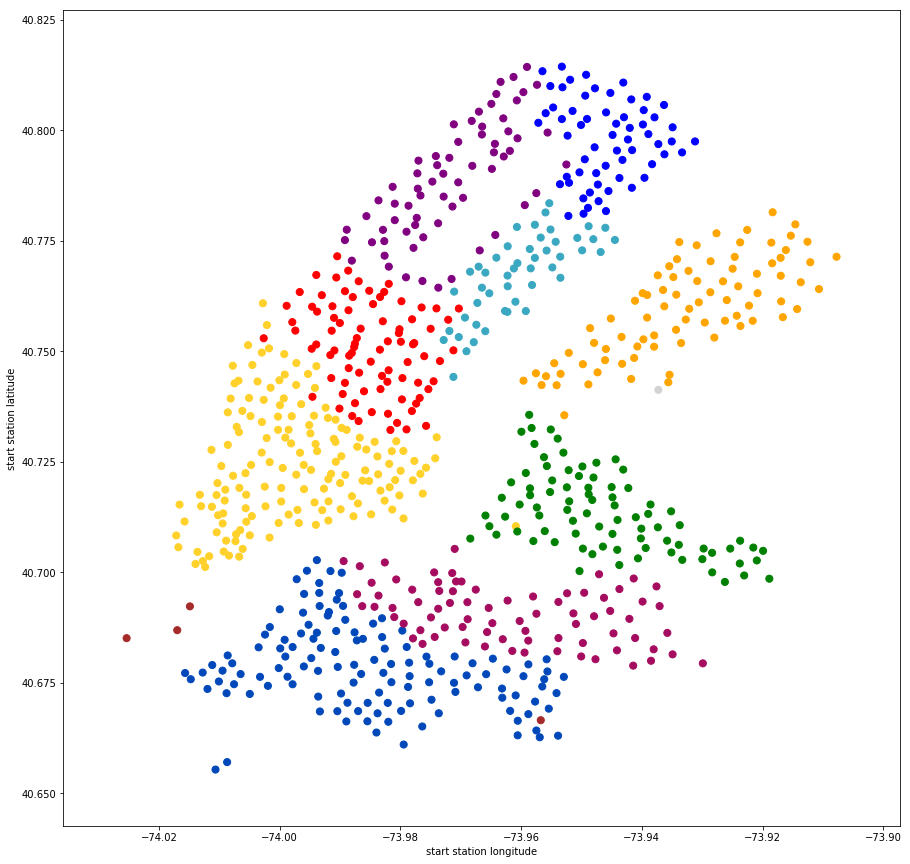

In [24]:
color_dict = {}
color_dict['cat-1'] = 'brown'
color_dict['cat-2'] = '#FFA500'
color_dict['cat-3'] = '#D3D3D3'
color_dict['cat-4'] = 'green'
color_dict['cat-5'] = '#0048BA'
color_dict['cat-6'] = '#A50B5E'
color_dict['cat-7'] = '#A50B5E'
color_dict['cat-8'] = '#FFD12A'
color_dict['cat-9'] = 'purple'
color_dict['cat-10'] = 'blue'
color_dict['cat-11'] = '#3AA8C1'
color_dict['cat-12'] = 'red'

color_list = [color_dict[df_meta.loc[x, 'Cluster']] for x in df_meta.index.tolist()]
df_meta.plot(kind='scatter', x='start station longitude', y='start station latitude', figsize=(15,15), c=color_list, s=50)

In [29]:
cat_colors = {}
for inst_clust in color_dict:
    inst_neighborhood = name_dict[inst_clust]
    inst_color = color_dict[inst_clust]
    cat_colors[inst_neighborhood] = inst_color

In [25]:
df_meta['Neighborhood'] = df_meta['Cluster'].apply(lambda x: name_dict[x])
df_meta['Neighborhood'].head()

Pershing Square North            Midtown
12 Ave & W 40 St         Lower Manhattan
West St & Chambers St    Lower Manhattan
8 Ave & W 31 St                  Midtown
E 17 St & Broadway               Midtown
Name: Neighborhood, dtype: object

### Add category for clusters

In [26]:
df_cat = deepcopy(df_dest)
add_cat_list = ['Neighborhood', 'cross-x', 'cross-y', 'departing age']
new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.columns.tolist(), df_meta=df_meta)

add_cat_list = ['Neighborhood', 'cross-x', 'cross-y', 'arriving age']
new_rows = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.index.tolist(), df_meta=df_meta)

df_norm.columns = new_cols
df_norm.index = new_rows

In [30]:
net.load_df(df_norm)
net.set_cat_colors(axis='col', cat_colors=cat_colors, cat_index=1, cat_title='Neighborhood')
net.set_cat_colors(axis='row', cat_colors=cat_colors, cat_index=1, cat_title='Neighborhood')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "1 Ave & E 110 St", "ini": 787, "clust": 110, "rank": 87, "rank…

In [31]:
df_export = net.export_df()
df_export.to_csv('../data/processed/citibike.csv')

In [32]:
!mkdir -p ../data/processed/
net.save_dict_to_json(inst_dict=net.viz, filename='../data/processed/pre-calc-viz.json', indent=False)

### Calculate UMAP

In [33]:
ini_cat_colors = net.viz['cat_colors']['col']['cat-0']
cat_colors = {}
for inst_key in ini_cat_colors:
    cat_colors[inst_key.split(': ')[1]] = ini_cat_colors[inst_key]

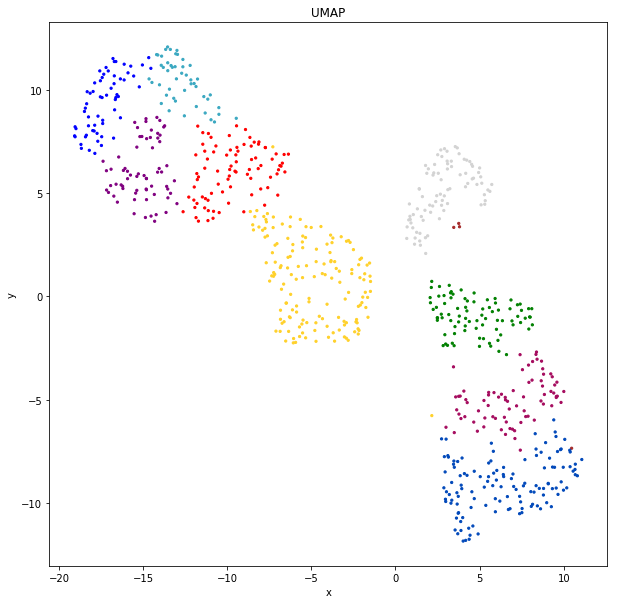

In [34]:
df_umap = make_umap_plot(df_norm, cat_index=1, title='UMAP', colors_dict=cat_colors)

In [35]:
df_umap.columns = ['umap-x', 'umap-y']
df_umap.index = df_meta.index.tolist()

In [36]:
df_new_meta = pd.concat([df_meta, df_umap], axis=1)

In [37]:
df_new_meta.head()

,station crossing,cross-y,cross-x,St,Ave,start station latitude,start station longitude,departing age,arriving age,Cluster,Neighborhood,umap-x,umap-y
Pershing Square North,Pershing Square North,Pershing Square North,Pershing Square North,N.A.,N.A.,40.751873,-73.977706,1.690176,2.188353,cat-12,Midtown,-17.201248,11.091014
12 Ave & W 40 St,12 Ave & W 40 St,12 Ave,W 40 St,W 40 St,12 Ave,40.760875,-74.002777,1.435184,1.386848,cat-8,Lower Manhattan,-6.363423,6.891482
West St & Chambers St,West St & Chambers St,West St,Chambers St,West St,N.A.,40.717548,-74.013221,-0.236967,-0.257055,cat-8,Lower Manhattan,-6.724182,6.455872
8 Ave & W 31 St,8 Ave & W 31 St,8 Ave,W 31 St,W 31 St,8 Ave,40.750585,-73.994685,2.172538,0.934610,cat-12,Midtown,-8.139073,7.374693
E 17 St & Broadway,E 17 St & Broadway,E 17 St,Broadway,E 17 St,N.A.,40.737050,-73.990093,0.143626,0.261608,cat-12,Midtown,-11.153826,9.556819


In [38]:
df_new_meta.to_csv('../data/processed/df_meta_v2.csv')